# Loan Approval Prediction

## Import library and datasets

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import mean_squared_error, accuracy_score, log_loss, roc_auc_score

from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.feature_selection import mutual_info_classif

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from scipy.stats import loguniform, uniform

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
data_dir = '/kaggle/input/playground-series-s4e10/'
raw_df = pd.read_csv(data_dir + 'train.csv')
test_df = pd.read_csv(data_dir + 'test.csv')
sub_df = pd.read_csv(data_dir + 'sample_submission.csv')

In [3]:
original_df = pd.read_csv('/kaggle/input/loan-approval-prediction/credit_risk_dataset.csv')

In [4]:
raw_df

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
58640,58640,34,120000,MORTGAGE,5.0,EDUCATION,D,25000,15.95,0.21,Y,10,0
58641,58641,28,28800,RENT,0.0,MEDICAL,C,10000,12.73,0.35,N,8,1
58642,58642,23,44000,RENT,7.0,EDUCATION,D,6800,16.00,0.15,N,2,1
58643,58643,22,30000,RENT,2.0,EDUCATION,A,5000,8.90,0.17,N,3,0


In [5]:
original_df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [6]:
concat_df = pd.concat([raw_df, test_df, original_df]).copy().reset_index(drop=True)
concat_df

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0.0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0.0
1,1.0,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0.0
2,2.0,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0.0
3,3.0,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0.0
4,4.0,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
130319,NaN,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0.11,N,30,0.0
130320,NaN,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0.15,N,19,0.0
130321,NaN,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,0.46,N,28,1.0
130322,NaN,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0.10,N,26,0.0


In [7]:
concat_df.isna().sum()

id                            32581
person_age                        0
person_income                     0
person_home_ownership             0
person_emp_length               895
loan_intent                       0
loan_grade                        0
loan_amnt                         0
loan_int_rate                  3116
loan_percent_income               0
cb_person_default_on_file         0
cb_person_cred_hist_length        0
loan_status                   39098
dtype: int64

In [8]:
concat_df['loan_status'].value_counts(normalize=True)

loan_status
0.0    0.830553
1.0    0.169447
Name: proportion, dtype: float64

In [9]:
def view_cat_target_feature_corr(
    df: pd.DataFrame,
    feature: str,
    target: str,
    is_numeric: bool=False,
    bins: int|list|None=None,
    labels: list|None=None
) -> pd.DataFrame:
    """
    Xem xét sự phụ thuộc của `df[target]` vào `df[feature]`, trong đó
    target là một category, còn feature có thể là dữ liệu numeric hoặc category.
    
    Parameters
    ----------
    df: DataFrame
        DataFrame để tham chiếu mối quan hệ
    feature: str
        Tên tính năng để xem xét mối quan hệ với cột đích.
    target: str
        Tên cột đích (cột cần dự đoán), mang dữ liệu phân loại
    is_numeric: bool, default=False
        Lựa chọn xem tính năng là numeric hay categorical:
        - Nếu là `False`, hàm sẽ đếm tỉ lệ phần trăm của mỗi nhãn đích
        trong mỗi nhãn của `feature`.
        - Nếu là `True`, hàm sẽ đem feature này phân ra tùy theo
        `bins` rồi chuyển về như làm với dữ liệu categorical.
    bins: int or list or None, default=None
        Số lượng bins để phân chia tính năng thành các dữ liệu categorical:
        - Nếu là `int` >= 2, hàm sẽ phân chia chính xác cột này thành `bins` labels.
        - Nếu là `list` với len()>=3, hàm sẽ chia cột này thành các phần có các đầu mút là
        các phần tử của `list`.
        - Nếu là `None`: Nếu feature này là numeric thì chia thành 10 bin, còn 
        nếu feature này là categorical thì số bin chính là số label. 
    labels: list or None, default=None
        Nếu là list, các label này được đánh lần lượt cho các bin, nếu là None
        thì label sẽ được đánh tự động theo thứ tự bin.
        
    Returns
    -------
    out_df: DataFrame
    Một DataFrame miêu tả mối quan hệ phụ thuộc
    """
    df = df[[feature, target]].copy()
    df = df[df[target].isna()==False]
    if is_numeric:
        if isinstance(bins, int) and bins>=2:
            if labels is None:
                labels = [i for i in range(bins)]
            else:
                if len(labels) > bins:
                    labels = labels[:bins]
                elif len(labels) < bins:
                    add_labels = [i for i in range(len(labels), bins)]
                    labels += add_labels
            df[f'cut_of_{feature}'] = pd.cut(df[feature], bins=bins, labels=labels)
        elif isinstance(bins, list) and len(bins)>=3:
            num_bins = len(bins) - 1
            if labels is None:
                labels = [i for i in range(num_bins)]
            else:
                if len(labels) > num_bins:
                    labels = labels[:num_bins]
                elif len(labels) < num_bins:
                    add_labels = [i for i in range(len(labels), num_bins)]
                    labels += add_labels
            df[f'cut_of_{feature}'] = pd.cut(df[feature], bins=bins, labels=labels)
        else:
            num_bins = 10
            if labels is None:
                labels = [i for i in range(num_bins)]
            else:
                if len(labels) > num_bins:
                    labels = labels[:num_bins]
                elif len(labels) < num_bins:
                    add_labels = [i for i in range(len(labels), num_bins)]
                    labels += add_labels
            df[f'cut_of_{feature}'] = pd.cut(df[feature], bins=bins, labels=labels)
    else:
        df[f'cut_of_{feature}'] = df[feature]
    
    feature_dict = dict()
    total = df[f'cut_of_{feature}'].value_counts()
    view_idx = df[target].value_counts().index.tolist()
    for idx in view_idx:
        label = df[df[target]==idx][f'cut_of_{feature}'].value_counts()
        feature_dict[idx] = label/total*100
    
    out_df = pd.DataFrame(feature_dict, columns=view_idx)
    return out_df

## EDA, Feature Engineering, Preprocessing

### Person Age

In [10]:
concat_df['person_age'].describe()

count    130324.000000
mean         27.601570
std           6.113756
min          20.000000
25%          23.000000
50%          26.000000
75%          30.000000
max         144.000000
Name: person_age, dtype: float64

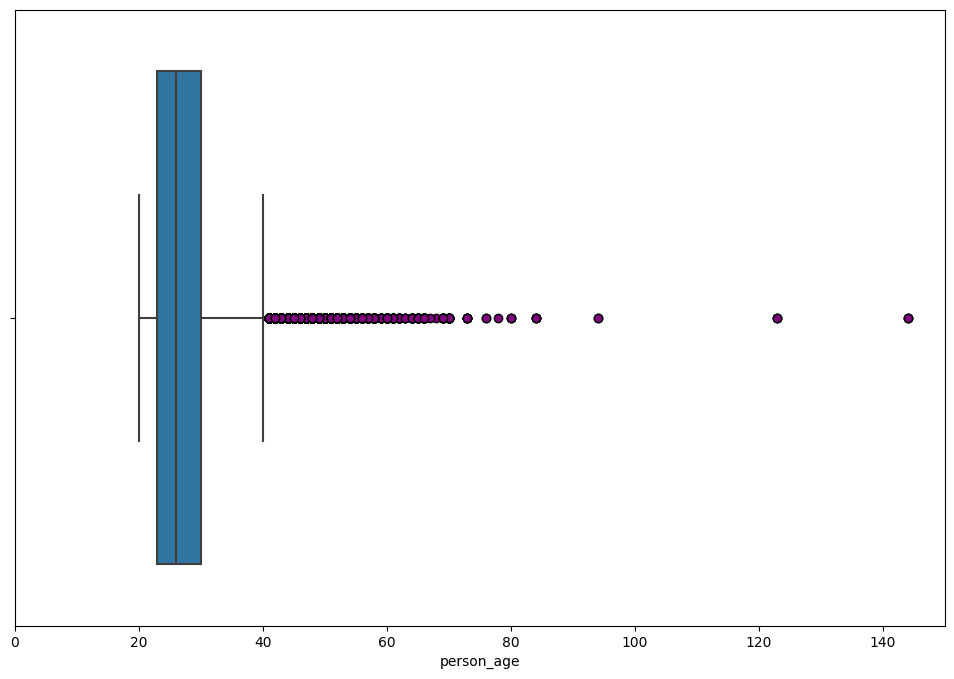

In [11]:
plt.figure(figsize=(12,8))
plt.xlim(0,150)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=concat_df['person_age'], flierprops=flierprops);

In [12]:
concat_df['person_age'] = concat_df['person_age'].clip(0,90)

In [13]:
view_cat_target_feature_corr(concat_df, 'person_age', 'loan_status', is_numeric=True, bins=6)

,0.0,1.0
cut_of_person_age,,
0,83.011840,16.988160
1,83.574219,16.425781
2,81.141692,18.858308
3,79.310345,20.689655
4,84.210526,15.789474
5,84.615385,15.384615


### Person income

In [14]:
concat_df['person_income'].describe()

count    1.303240e+05
mean     6.455763e+04
std      4.517574e+04
min      4.000000e+03
25%      4.100000e+04
50%      5.718150e+04
75%      7.724800e+04
max      6.000000e+06
Name: person_income, dtype: float64

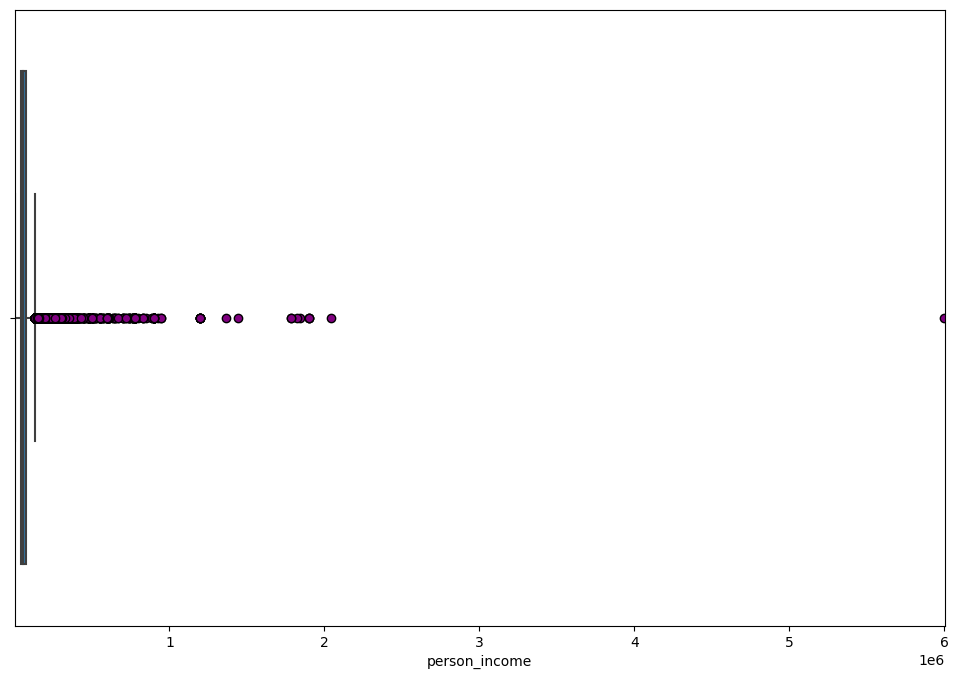

In [15]:
plt.figure(figsize=(12,8))
plt.xlim(3000,6e6+3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=concat_df['person_income'], flierprops=flierprops);

In [16]:
concat_df['person_income'] = concat_df['person_income'].clip(0,7e5)

In [17]:
view_cat_target_feature_corr(concat_df, 'person_income', 'loan_status', is_numeric=True, bins=11)

,0.0,1.0
cut_of_person_income,,
0,78.216359,21.783641
1,91.639419,8.360581
2,93.730939,6.269061
3,93.707483,6.292517
4,91.275168,8.724832
5,94.545455,5.454545
6,89.655172,10.344828
7,92.857143,7.142857
8,91.666667,8.333333


### Person Home Ownership

In [18]:
concat_df['person_home_ownership'].value_counts()

person_home_ownership
RENT        67320
MORTGAGE    54951
OWN          7778
OTHER         275
Name: count, dtype: int64

In [19]:
view_cat_target_feature_corr(concat_df, 'person_home_ownership', 'loan_status')

,0.0,1.0
cut_of_person_home_ownership,,
MORTGAGE,91.708477,8.291523
OTHER,75.510204,24.489796
OWN,95.875568,4.124432
RENT,74.487670,25.512330


In [20]:
concat_df['person_home_ownership'] = concat_df['person_home_ownership'].map({
    'OWN': 1,
    'MORTGAGE': 2,
    'OTHER': 3,
    'RENT': 4
})

### Person Emp Length

In [21]:
concat_df['person_emp_length'].describe()

count    129429.000000
mean          4.718510
std           3.978429
min           0.000000
25%           2.000000
50%           4.000000
75%           7.000000
max         123.000000
Name: person_emp_length, dtype: float64

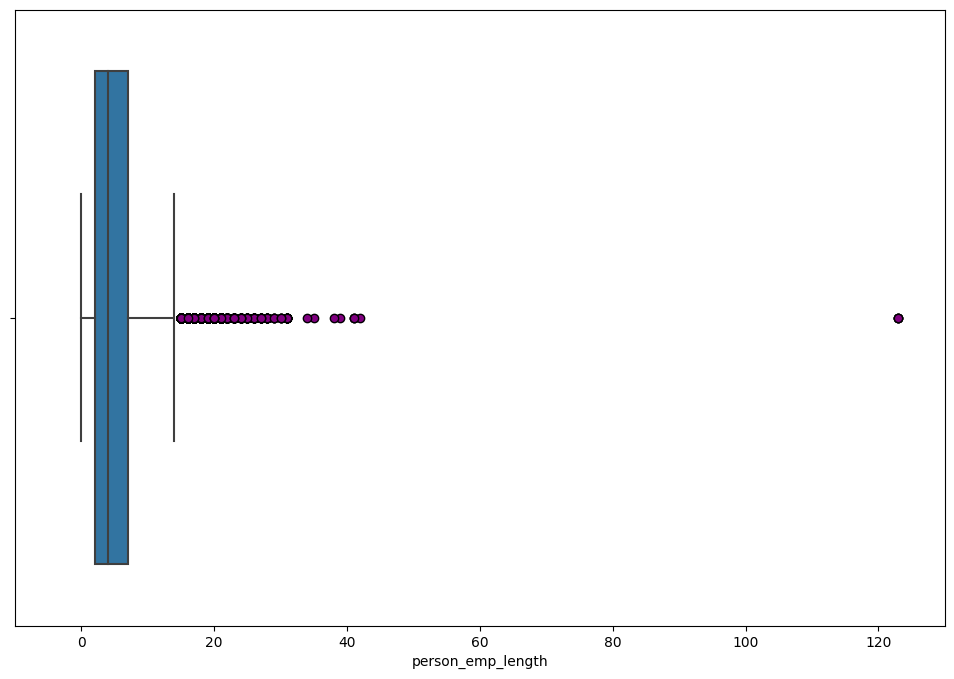

In [22]:
plt.figure(figsize=(12,8))
plt.xlim(-10,130)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=concat_df['person_emp_length'], flierprops=flierprops);

In [23]:
concat_df['person_emp_length'] = concat_df['person_emp_length'].clip(0,25)

In [24]:
mean = concat_df['person_emp_length'].mean()
concat_df.fillna({'person_emp_length': mean}, inplace=True)

In [25]:
view_cat_target_feature_corr(concat_df, 'person_emp_length', 'loan_status', is_numeric=True, bins=6)

,0.0,1.0
cut_of_person_emp_length,,
0,79.958938,20.041062
1,86.073678,13.926322
2,87.767781,12.232219
3,89.462164,10.537836
4,86.825596,13.174404
5,79.642857,20.357143


### Loan intent

In [26]:
concat_df['loan_intent'].value_counts()

loan_intent
EDUCATION            26800
MEDICAL              24452
VENTURE              22362
PERSONAL             22352
DEBTCONSOLIDATION    20260
HOMEIMPROVEMENT      14098
Name: count, dtype: int64

In [27]:
view_cat_target_feature_corr(concat_df, 'loan_intent', 'loan_status')

,0.0,1.0
cut_of_loan_intent,,
DEBTCONSOLIDATION,77.560125,22.439875
EDUCATION,87.005982,12.994018
HOMEIMPROVEMENT,79.443601,20.556399
MEDICAL,79.006175,20.993825
PERSONAL,84.372788,15.627212
VENTURE,88.709472,11.290528


In [28]:
concat_df['loan_intent'] = concat_df['loan_intent'].map({
    'VENTURE': 1,
    'EDUCATION': 2,
    'PERSONAL': 3,
    'HOMEIMPROVEMENT': 4,
    'MEDICAL': 5,
    'DEBTCONSOLIDATION': 6
})

### Loan Grade

In [29]:
concat_df['loan_grade'].value_counts()

loan_grade
A    45766
B    44455
C    24954
D    11929
E     2610
F      495
G      115
Name: count, dtype: int64

In [30]:
view_cat_target_feature_corr(concat_df, 'loan_grade', 'loan_status')

,0.0,1.0
cut_of_loan_grade,,
A,93.372375,6.627625
B,87.721630,12.278370
C,83.805876,16.194124
D,40.773672,59.226328
E,36.543335,63.456665
F,33.076923,66.923077
G,7.216495,92.783505


In [31]:
concat_df['loan_grade'] = concat_df['loan_grade'].map({
    'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7
})

### Loan amnt

In [32]:
concat_df['loan_amnt'].describe()

count    130324.000000
mean       9320.683274
std        5768.405599
min         500.000000
25%        5000.000000
50%        8000.000000
75%       12000.000000
max       35000.000000
Name: loan_amnt, dtype: float64

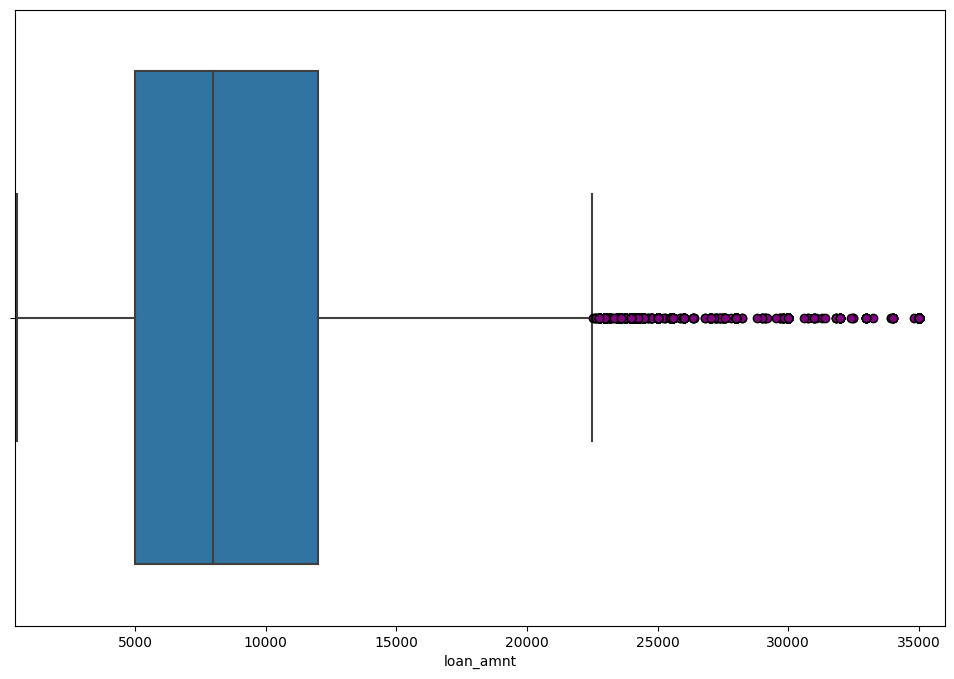

In [33]:
plt.figure(figsize=(12,8))
plt.xlim(400,36000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=concat_df['loan_amnt'], flierprops=flierprops);

In [34]:
view_cat_target_feature_corr(concat_df, 'loan_amnt', 'loan_status', is_numeric=True, bins=11)

,0.0,1.0
cut_of_loan_amnt,,
0,84.840958,15.159042
1,87.477511,12.522489
2,85.428841,14.571159
3,83.826479,16.173521
4,76.896855,23.103145
5,73.273761,26.726239
6,71.775083,28.224917
7,67.043189,32.956811
8,71.739130,28.260870


### Loan int rate

In [35]:
concat_df['loan_int_rate'].describe()

count    127208.000000
mean         10.750077
std           3.082540
min           5.420000
25%           7.880000
50%          10.830000
75%          13.060000
max          23.220000
Name: loan_int_rate, dtype: float64

In [36]:
mean = concat_df['loan_int_rate'].mean()
concat_df.fillna({'loan_int_rate': mean}, inplace=True)

In [37]:
view_cat_target_feature_corr(concat_df, 'loan_int_rate', 'loan_status', is_numeric=True, bins=6)

,0.0,1.0
cut_of_loan_int_rate,,
0,93.961531,6.038469
1,87.930003,12.069997
2,83.530374,16.469626
3,48.786985,51.213015
4,36.407378,63.592622
5,23.076923,76.923077


### Loan percent income

In [38]:
concat_df['loan_percent_income'].describe()

count    130324.000000
mean          0.162080
std           0.095785
min           0.000000
25%           0.090000
50%           0.140000
75%           0.210000
max           0.830000
Name: loan_percent_income, dtype: float64

In [39]:
view_cat_target_feature_corr(concat_df, 'loan_percent_income', 'loan_status', is_numeric=True, bins=6)

,0.0,1.0
cut_of_loan_percent_income,,
0,91.410682,8.589318
1,86.210391,13.789609
2,47.839801,52.160199
3,25.771325,74.228675
4,21.568627,78.431373
5,23.076923,76.923077


### CB Person Default on File

In [40]:
concat_df['cb_person_default_on_file'].value_counts()

cb_person_default_on_file
N    110006
Y     20318
Name: count, dtype: int64

In [41]:
view_cat_target_feature_corr(concat_df, 'cb_person_default_on_file', 'loan_status')

,0.0,1.0
cut_of_cb_person_default_on_file,,
N,86.083434,13.916566
Y,66.961999,33.038001


In [42]:
concat_df['cb_person_default_on_file'] = concat_df['cb_person_default_on_file'].map({
    'N': 0, 'Y': 1
})

### CB Person Credit Hist Length

In [43]:
concat_df['cb_person_cred_hist_length'].describe()

count    130324.000000
mean          5.816365
std           4.048560
min           2.000000
25%           3.000000
50%           4.000000
75%           8.000000
max          30.000000
Name: cb_person_cred_hist_length, dtype: float64

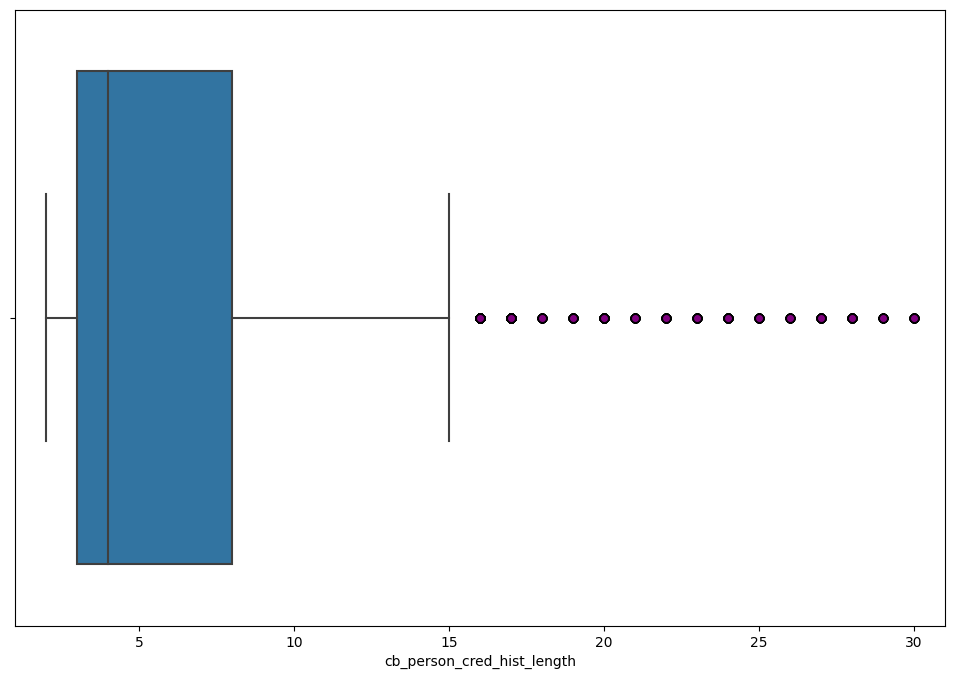

In [44]:
plt.figure(figsize=(12,8))
plt.xlim(1,31)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=concat_df['cb_person_cred_hist_length'], flierprops=flierprops);

In [45]:
view_cat_target_feature_corr(concat_df, 'cb_person_cred_hist_length', 'loan_status', is_numeric=True, bins=6)

,0.0,1.0
cut_of_cb_person_cred_hist_length,,
0,82.672067,17.327933
1,84.230786,15.769214
2,82.852292,17.147708
3,83.907186,16.092814
4,78.073090,21.926910
5,76.383764,23.616236


### New features

In [46]:
concat_df['ratio_person_income_person_age'] = concat_df['person_income'] / concat_df['person_age']

In [47]:
view_cat_target_feature_corr(concat_df, 'ratio_person_income_person_age', 'loan_status', is_numeric=True, bins=6)

,0.0,1.0
cut_of_ratio_person_income_person_age,,
0,82.733943,17.266057
1,93.824619,6.175381
2,93.700787,6.299213
3,98.214286,1.785714
4,83.333333,16.666667
5,100.000000,0.000000


In [48]:
concat_df['ratio_person_income_person_emp_length'] = concat_df['person_income'] / (concat_df['person_emp_length']+0.5)

In [49]:
view_cat_target_feature_corr(concat_df, 'ratio_person_income_person_emp_length', 'loan_status', is_numeric=True, bins=6)

,0.0,1.0
cut_of_ratio_person_income_person_emp_length,,
0,82.976726,17.023274
1,93.113772,6.886228
2,96.000000,4.000000
3,100.000000,0.000000
4,100.000000,0.000000
5,100.000000,0.000000


In [50]:
concat_df['sum_person_age_person_emp_lenth'] = concat_df['person_age'] + concat_df['person_emp_length']
concat_df['ratio_person_age_person_emp_lenth'] = concat_df['person_emp_length'] / concat_df['person_age']

In [51]:
view_cat_target_feature_corr(concat_df, 'ratio_person_age_person_emp_lenth', 'loan_status', is_numeric=True, bins=6)

,0.0,1.0
cut_of_ratio_person_age_person_emp_lenth,,
0,80.541075,19.458925
1,86.626651,13.373349
2,88.671875,11.328125
3,80.555556,19.444444
4,50.000000,50.000000
5,66.666667,33.333333


In [52]:
concat_df['person_loan'] = concat_df['person_income'] * concat_df['loan_percent_income']

In [53]:
view_cat_target_feature_corr(concat_df, 'person_loan', 'loan_status', is_numeric=True, bins=6)

,0.0,1.0
cut_of_person_loan,,
0,83.536364,16.463636
1,69.903517,30.096483
2,50.000000,50.000000
3,100.000000,0.000000
4,100.000000,0.000000
5,100.000000,0.000000


In [54]:
concat_df['count_cat'] = concat_df['person_home_ownership'] + concat_df['loan_intent'] + concat_df['loan_grade'] + concat_df['cb_person_default_on_file']

In [55]:
view_cat_target_feature_corr(concat_df, 'count_cat', 'loan_status')

,0.0,1.0
cut_of_count_cat,,
3,98.011364,1.988636
4,99.388223,0.611777
5,98.365808,1.634192
6,94.956190,5.043810
7,91.534525,8.465475
8,88.444097,11.555903
9,85.707591,14.292409
10,80.474158,19.525842
11,76.332835,23.667165


### Preprocessing

In [56]:
concat_df['id'] = concat_df.index

In [57]:
raw_df['id'].max(), test_df['id'].max()

(58644, 97742)

In [58]:
raw_df = concat_df[concat_df['id']<=58644]
test_df = concat_df[(concat_df['id']>58644) & (concat_df['id']<=97742)]
original_df = concat_df[concat_df['id']>97742]

In [59]:
concat_df = pd.concat([raw_df, original_df]).copy()

In [60]:
input_cols = concat_df.columns.tolist()
input_cols.remove('id')
input_cols.remove('loan_status')

In [61]:
for df in [raw_df, original_df, concat_df]:
    df['loan_status'] = df['loan_status'].astype('int8')

/tmp/ipykernel_23/1421540899.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loan_status'] = df['loan_status'].astype('int8')
/tmp/ipykernel_23/1421540899.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['loan_status'] = df['loan_status'].astype('int8')


### Mutual info

In [62]:
inputs, targets = concat_df[input_cols], concat_df['loan_status']

In [63]:
%%time
mutual_info = mutual_info_classif(inputs, targets, random_state=42)
mutual_info = pd.Series(mutual_info)
mutual_info.index = inputs.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns = ["Numerical_Feature_MI"] )

CPU times: user 7.11 s, sys: 30.9 ms, total: 7.14 s
Wall time: 7.14 s


In [64]:
mutual_info.style.background_gradient('cool')

,Numerical_Feature_MI
person_income,0.114581
ratio_person_income_person_age,0.087409
loan_percent_income,0.081940
loan_int_rate,0.080742
loan_grade,0.079295
person_loan,0.078746
count_cat,0.075551
ratio_person_income_person_emp_length,0.073490
person_home_ownership,0.034720
loan_amnt,0.016073


## Training model

In [65]:
def cross_validation(clf, cv, inputs, targets, test_inputs=None, need_print=False):
    train_accs = []
    val_accs = []
    if test_inputs is not None:
        test_preds = np.zeros(len(test_inputs))
    else:
        test_preds = np.zeros(len(inputs))
    for fold, (train_idx, val_idx) in enumerate(cv.split(inputs, targets)):
        X_train = inputs.iloc[train_idx].reset_index(drop=True)
        y_train = targets.iloc[train_idx].reset_index(drop=True)
        X_val = inputs.iloc[val_idx].reset_index(drop=True)
        y_val = targets.iloc[val_idx].reset_index(drop=True)

        clf.fit(X_train, y_train)

        train_pred = clf.predict_proba(X_train)[:,1]
        train_acc = roc_auc_score(y_train, train_pred)
        train_accs.append(train_acc)
        val_pred = clf.predict_proba(X_val)[:,1]
        val_acc = roc_auc_score(y_val, val_pred)
        val_accs.append(val_acc)

        if need_print:
            print(f'Fold {fold}: train_acc = {train_acc:.5f}, val_acc = {val_acc:.5f}')

        if test_inputs is not None:
            test_pred = clf.predict_proba(test_inputs)[:,1]
            test_preds += test_pred/cv.get_n_splits()
            
    m_train_acc = np.mean(train_accs)
    s_train_acc = np.std(train_accs)
    m_val_acc = np.mean(val_accs)
    s_val_acc = np.std(val_accs)
    
    msg = f'{m_val_acc:.7f} ± {s_val_acc:.7f}'
    
    if need_print:
        print(f'Train acc: {m_train_acc:.7f} ± {s_train_acc:.7f} | Val acc: {m_val_acc:.7f} ± {s_val_acc:.7f}')
    return test_preds, msg

In [66]:
def test_with_models(models: dict, features: dict, 
                     df: pd.DataFrame, target: str, cv):
    result = dict()
    result['Classifier'] = []
    for feature, _ in features.items():
        result[f'Acc with {feature} features'] = []
    targets = df[target]
    for name, model in models.items():
        result['Classifier'].append(name)
        for f_name, feature in features.items():
            inputs = df[feature]
            _, msg = cross_validation(model, cv, 
                                         inputs, targets,
                                         test_inputs=None, 
                                         need_print=False)
            result[f'Acc with {f_name} features'].append(msg)
    
    return pd.DataFrame(result)

In [67]:
classifiers = {
    'Logit': LogisticRegression(n_jobs=-1, max_iter=1000),
    'RandomForest': RandomForestClassifier(n_jobs=-1),
    'XGB': XGBClassifier(n_jobs=-1, device='cuda'),
    'LGBM' : LGBMClassifier(n_jobs=-1,verbose=-1),
    'CAT': CatBoostClassifier(logging_level='Silent')
}
features = {
    'all': input_cols
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [68]:
%%time
test_with_models(classifiers, features, raw_df, 'loan_status', cv)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [14:16:44] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


CPU times: user 4min 21s, sys: 14.4 s, total: 4min 36s
Wall time: 1min 18s


,Classifier,Acc with all features
0,Logit,0.8605737 ± 0.0040612
1,RandomForest,0.9354109 ± 0.0064318
2,XGB,0.9522707 ± 0.0050889
3,LGBM,0.9556220 ± 0.0044400
4,CAT,0.9558991 ± 0.0052875


In [69]:
%%time
test_with_models(classifiers, features, concat_df, 'loan_status', cv)

CPU times: user 6min 24s, sys: 17.1 s, total: 6min 41s
Wall time: 1min 49s


,Classifier,Acc with all features
0,Logit,0.8467086 ± 0.0057536
1,RandomForest,0.9408051 ± 0.0035346
2,XGB,0.9564566 ± 0.0028088
3,LGBM,0.9559956 ± 0.0028102
4,CAT,0.9569839 ± 0.0033183


In [70]:
scores = {
    'Classifier': [],
    'Train Score': [],
    'Val Score': [],
    'Test Score': []
}

In [71]:
inputs, targets = concat_df[input_cols], concat_df['loan_status']
test_inputs = test_df[input_cols]

### Random Forest

In [72]:
%%time
clf = RandomForestClassifier(n_jobs=-1)
test_preds, _ = cross_validation(clf, cv, inputs, targets, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_acc = 1.00000, val_acc = 0.94348
Fold 1: train_acc = 1.00000, val_acc = 0.94237
Fold 2: train_acc = 1.00000, val_acc = 0.93977
Fold 3: train_acc = 1.00000, val_acc = 0.93335
Fold 4: train_acc = 1.00000, val_acc = 0.94462
Train acc: 0.9999998 ± 0.0000002 | Val acc: 0.9407189 ± 0.0040186
CPU times: user 2min 11s, sys: 461 ms, total: 2min 11s
Wall time: 34.7 s


In [73]:
sub_df['loan_status'] = test_preds
sub_df.to_csv('/kaggle/working/sub_rf.csv', index=None)

In [74]:
scores['Classifier'].append('RF without tuning')
scores['Train Score'].append(1.00000)
scores['Val Score'].append(0.94060)
scores['Test Score'].append(0.94661)

### XGB

In [75]:
%%time
clf = XGBClassifier(n_jobs=-1, device='cuda')
test_preds, _ = cross_validation(clf, cv, inputs, targets, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_acc = 0.98367, val_acc = 0.95936
Fold 1: train_acc = 0.98257, val_acc = 0.95857
Fold 2: train_acc = 0.98380, val_acc = 0.95420
Fold 3: train_acc = 0.98353, val_acc = 0.95210
Fold 4: train_acc = 0.98326, val_acc = 0.95805
Train acc: 0.9833671 ± 0.0004365 | Val acc: 0.9564566 ± 0.0028088
CPU times: user 4.62 s, sys: 50.8 ms, total: 4.67 s
Wall time: 2.11 s


In [76]:
sub_df['loan_status'] = test_preds
sub_df.to_csv('/kaggle/working/sub_xgb.csv', index=None)

In [77]:
scores['Classifier'].append('XGB without tuning')
scores['Train Score'].append(0.98337)
scores['Val Score'].append(0.95646)
scores['Test Score'].append(0.96417)

In [78]:
param_dis = {
    'n_estimators': np.arange(100,600,150),
    'max_depth': np.arange(8,17,2),
    'learning_rate': loguniform(0.009,0.25),
    'reg_lambda': loguniform(1e-5,5),
    'subsample': loguniform(0.5,1),
    'min_child_weight': loguniform(0.4,5),
    'eval_metric': ['auc'],
    'tree_method': ['hist'],
    'colsample_bytree': loguniform(0.25,1),
    'nthread': [2],
    'n_jobs': [-1],
    'device': ['cuda'],
    'max_bin': [256,512]
}

In [79]:
'''%%time
search = RandomizedSearchCV(XGBClassifier(), param_dis, 
                            n_iter=200, refit=True,
                            scoring = 'roc_auc',
                            cv=cv, verbose=3)
search.fit(inputs, targets)'''

"%%time\nsearch = RandomizedSearchCV(XGBClassifier(), param_dis, \n                            n_iter=200, refit=True,\n                            scoring = 'roc_auc',\n                            cv=cv, verbose=3)\nsearch.fit(inputs, targets)"

In [80]:
xgb_best_params = {
 'colsample_bytree': 0.32971357590936407,
 'device': 'cuda',
 'eval_metric': 'auc',
 'learning_rate': 0.02959320825872786,
 'max_bin': 512,
 'max_depth': 12,
 'min_child_weight': 3.33437449731815,
 'n_estimators': 550,
 'n_jobs': -1,
 'nthread': 2,
 'reg_lambda': 0.017941202696813808,
 'subsample': 0.8970317237668648,
 'tree_method': 'hist'
}

In [81]:
%%time
clf = XGBClassifier(**xgb_best_params)
test_preds, _ = cross_validation(clf, cv, inputs, targets, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_acc = 0.99745, val_acc = 0.96111
Fold 1: train_acc = 0.99744, val_acc = 0.96007
Fold 2: train_acc = 0.99755, val_acc = 0.95644
Fold 3: train_acc = 0.99772, val_acc = 0.95345
Fold 4: train_acc = 0.99752, val_acc = 0.96000
Train acc: 0.9975364 ± 0.0001008 | Val acc: 0.9582136 ± 0.0028584
CPU times: user 29.3 s, sys: 171 ms, total: 29.4 s
Wall time: 27.3 s


In [82]:
sub_df['loan_status'] = test_preds
sub_df.to_csv('/kaggle/working/sub_xgb_tuning.csv', index=None)

In [83]:
scores['Classifier'].append('XGB with tuning')
scores['Train Score'].append(0.99754)
scores['Val Score'].append(0.95821)
scores['Test Score'].append(0.96250)

### LGBM

In [84]:
%%time
clf = LGBMClassifier(n_jobs=-1, verbose=-1)
test_preds, _ = cross_validation(clf, cv, inputs, targets, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_acc = 0.96898, val_acc = 0.95881
Fold 1: train_acc = 0.96926, val_acc = 0.95688
Fold 2: train_acc = 0.96950, val_acc = 0.95382
Fold 3: train_acc = 0.97017, val_acc = 0.95171
Fold 4: train_acc = 0.97042, val_acc = 0.95877
Train acc: 0.9696662 ± 0.0005466 | Val acc: 0.9559956 ± 0.0028102
CPU times: user 18.4 s, sys: 122 ms, total: 18.6 s
Wall time: 4.7 s


In [85]:
sub_df['loan_status'] = test_preds
sub_df.to_csv('/kaggle/working/sub_lgbm.csv', index=None)

In [86]:
scores['Classifier'].append('LGBM without tuning')
scores['Train Score'].append(0.96967)
scores['Val Score'].append(0.95599)
scores['Test Score'].append(0.96050)

In [87]:
param_dis = {
    'num_leaves': np.arange(32,300,7),
    'n_jobs': [-1],
    'reg_lambda': loguniform(1e-5,4),
    'reg_alpha': loguniform(1e-5,4),
    'n_estimators': np.arange(50,541,40),
    'learning_rate': loguniform(0.001,0.2),
    'max_depth': np.arange(15,55,4),
    'min_split_gain': loguniform(1e-8,0.1),
    'min_child_weight': loguniform(1e-4,0.1),
    'min_child_samples': np.arange(8,30,4),
    'subsample': loguniform(0.25,1),
    'colsample_bytree': loguniform(0.25,1),
    'random_state': [42],
    'verbose': [-1]
}

In [88]:
'''%%time
search = RandomizedSearchCV(LGBMClassifier(), param_dis, 
                            n_iter=200, refit=True,
                            scoring = 'roc_auc',
                            cv=cv, verbose=3)
search.fit(inputs, targets)'''

"%%time\nsearch = RandomizedSearchCV(LGBMClassifier(), param_dis, \n                            n_iter=200, refit=True,\n                            scoring = 'roc_auc',\n                            cv=cv, verbose=3)\nsearch.fit(inputs, targets)"

In [89]:
lgbm_best_params = {
 'colsample_bytree': 0.4610940402872837,
 'learning_rate': 0.04354979569873756,
 'max_depth': 27,
 'min_child_samples': 12,
 'min_child_weight': 0.0015737488805846055,
 'min_split_gain': 1.0489063189376473e-06,
 'n_estimators': 530,
 'n_jobs': -1,
 'num_leaves': 60,
 'random_state': 42,
 'reg_alpha': 0.004866182336617388,
 'reg_lambda': 0.0016145837316783641,
 'subsample': 0.44042948580194596,
 'verbose': -1
}

In [90]:
%%time
clf = LGBMClassifier(**lgbm_best_params)
test_preds, _ = cross_validation(clf, cv, inputs, targets, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_acc = 0.99076, val_acc = 0.96212
Fold 1: train_acc = 0.99122, val_acc = 0.96053
Fold 2: train_acc = 0.99172, val_acc = 0.95744
Fold 3: train_acc = 0.99187, val_acc = 0.95573
Fold 4: train_acc = 0.99162, val_acc = 0.96112
Train acc: 0.9914387 ± 0.0004004 | Val acc: 0.9593855 ± 0.0024046
CPU times: user 1min 24s, sys: 266 ms, total: 1min 25s
Wall time: 22 s


In [91]:
sub_df['loan_status'] = test_preds
sub_df.to_csv('/kaggle/working/sub_lgbm_tuning.csv', index=None)

In [92]:
scores['Classifier'].append('LGBM with tuning')
scores['Train Score'].append(0.99144)
scores['Val Score'].append(0.95939)
scores['Test Score'].append(0.96424)

### CatBoost

In [93]:
%%time
clf = CatBoostClassifier(logging_level='Silent')
test_preds, _ = cross_validation(clf, cv, inputs, targets, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_acc = 0.97417, val_acc = 0.96022
Fold 1: train_acc = 0.97447, val_acc = 0.95878
Fold 2: train_acc = 0.97488, val_acc = 0.95494
Fold 3: train_acc = 0.97591, val_acc = 0.95144
Fold 4: train_acc = 0.97573, val_acc = 0.95954
Train acc: 0.9750325 ± 0.0006823 | Val acc: 0.9569839 ± 0.0033183
CPU times: user 3min 55s, sys: 14.4 s, total: 4min 9s
Wall time: 1min 5s


In [94]:
sub_df['loan_status'] = test_preds
sub_df.to_csv('/kaggle/working/sub_cat.csv', index=None)

In [95]:
scores['Classifier'].append('CAT without tuning')
scores['Train Score'].append(0.97503)
scores['Val Score'].append(0.95698)
scores['Test Score'].append(0.96481)

In [96]:
param_dis = {
    'eval_metric': ['AUC'],
    'iterations': np.arange(750,2000,250),
    'learning_rate': loguniform(0.008,0.21),
    'random_seed': [42],
    'l2_leaf_reg': loguniform(0.8,50),
    'bagging_temperature': loguniform(1e-4,1),
    'random_strength': np.arange(1,10),
    'depth': np.arange(6,10),
    'min_data_in_leaf': np.arange(1,5),
    'border_count': np.arange(24,256,50),
    'logging_level': ['Silent'],
    'task_type': ['GPU']
}

In [97]:
'''%%time
search = RandomizedSearchCV(CatBoostClassifier(), param_dis, 
                            n_iter=150, refit=True,
                            scoring = 'roc_auc',
                            cv=cv, verbose=3)
search.fit(inputs, targets)'''

"%%time\nsearch = RandomizedSearchCV(CatBoostClassifier(), param_dis, \n                            n_iter=150, refit=True,\n                            scoring = 'roc_auc',\n                            cv=cv, verbose=3)\nsearch.fit(inputs, targets)"

In [98]:
cat_best_params = {
 'bagging_temperature': 0.014163798543005526,
 'border_count': 224,
 'depth': 7,
 'eval_metric': 'AUC',
 'iterations': 1750,
 'l2_leaf_reg': 18.19432247981442,
 'learning_rate': 0.0813630363812761,
 'logging_level': 'Silent',
 'min_data_in_leaf': 3,
 'random_seed': 42,
 'random_strength': 7
}

In [99]:
%%time
clf = CatBoostClassifier(**cat_best_params)
test_preds, _ = cross_validation(clf, cv, inputs, targets, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_acc = 0.98420, val_acc = 0.96099
Fold 1: train_acc = 0.98467, val_acc = 0.96014
Fold 2: train_acc = 0.98328, val_acc = 0.95546
Fold 3: train_acc = 0.98698, val_acc = 0.95280
Fold 4: train_acc = 0.98652, val_acc = 0.95991
Train acc: 0.9851283 ± 0.0014018 | Val acc: 0.9578590 ± 0.0031801
CPU times: user 7min 28s, sys: 30.7 s, total: 7min 59s
Wall time: 2min 5s


In [100]:
sub_df['loan_status'] = test_preds
sub_df.to_csv('/kaggle/working/sub_cat_tuning.csv', index=None)

In [101]:
scores['Classifier'].append('CAT with tuning')
scores['Train Score'].append(0.98513)
scores['Val Score'].append(0.95786)
scores['Test Score'].append(0.96582)

In [102]:
cat_cols = concat_df[input_cols].select_dtypes(include='int64').columns.tolist()

In [103]:
%%time
clf = CatBoostClassifier(**cat_best_params, cat_features=cat_cols)
test_preds, _ = cross_validation(clf, cv, inputs, targets, 
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_acc = 0.98846, val_acc = 0.96892
Fold 1: train_acc = 0.98934, val_acc = 0.96733
Fold 2: train_acc = 0.99002, val_acc = 0.96550
Fold 3: train_acc = 0.99068, val_acc = 0.96423
Fold 4: train_acc = 0.99016, val_acc = 0.96597
Train acc: 0.9897329 ± 0.0007658 | Val acc: 0.9663912 ± 0.0016073
CPU times: user 56min 56s, sys: 1min 23s, total: 58min 19s
Wall time: 15min 8s


In [104]:
sub_df['loan_status'] = test_preds
sub_df.to_csv('/kaggle/working/sub_cat_tuning_cat.csv', index=None)

In [105]:
scores['Classifier'].append('CAT with tuning, set cat')
scores['Train Score'].append(0.98973)
scores['Val Score'].append(0.96639)
scores['Test Score'].append(0.97275)

### Voting

In [106]:
%%time
ests = list()
ests.append(('rf', RandomForestClassifier(n_jobs=-1)))
ests.append(('xgb', XGBClassifier(n_jobs=-1, device='cuda')))
ests.append(('lgbm', LGBMClassifier(**lgbm_best_params)))
ests.append(('cat', CatBoostClassifier(**cat_best_params, cat_features=cat_cols)))

weights = [0.03,0.07,0.1,0.8]

clf = VotingClassifier(ests, voting='soft', weights=weights)
test_preds, _ = cross_validation(clf, cv, inputs, targets,
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_acc = 0.99274, val_acc = 0.96949
Fold 1: train_acc = 0.99315, val_acc = 0.96813
Fold 2: train_acc = 0.99360, val_acc = 0.96604
Fold 3: train_acc = 0.99395, val_acc = 0.96477
Fold 4: train_acc = 0.99364, val_acc = 0.96689
Train acc: 0.9934161 ± 0.0004220 | Val acc: 0.9670626 ± 0.0016334
CPU times: user 1h 43s, sys: 1min 25s, total: 1h 2min 8s
Wall time: 16min 8s


In [107]:
sub_df['loan_status'] = test_preds
sub_df.to_csv('/kaggle/working/sub_rf3_xgb7_lgbm10_cat80.csv', index=None)

In [108]:
scores['Classifier'].append('RF(3),XGB(7),LGBM(10),CAT(80)')
scores['Train Score'].append(0.99341)
scores['Val Score'].append(0.96706)
scores['Test Score'].append(0.97256)

In [109]:
%%time
ests = list()
ests.append(('rf', RandomForestClassifier(n_jobs=-1)))
ests.append(('xgb', XGBClassifier(n_jobs=-1, device='cuda')))
ests.append(('lgbm', LGBMClassifier(**lgbm_best_params)))
ests.append(('cat', CatBoostClassifier(**cat_best_params, cat_features=cat_cols)))

weights = [0.01,0.04,0.05,0.90]

clf = VotingClassifier(ests, voting='soft', weights=weights)
test_preds, _ = cross_validation(clf, cv, inputs, targets,
                                 need_print=True, test_inputs=test_inputs)

Fold 0: train_acc = 0.99073, val_acc = 0.96930
Fold 1: train_acc = 0.99134, val_acc = 0.96788
Fold 2: train_acc = 0.99190, val_acc = 0.96591
Fold 3: train_acc = 0.99238, val_acc = 0.96469
Fold 4: train_acc = 0.99198, val_acc = 0.96659
Train acc: 0.9916659 ± 0.0005731 | Val acc: 0.9668753 ± 0.0015931
CPU times: user 1h 41s, sys: 1min 25s, total: 1h 2min 7s
Wall time: 16min 7s


In [110]:
sub_df['loan_status'] = test_preds
sub_df.to_csv('/kaggle/working/sub_rf1_xgb4_lgbm5_cat90.csv', index=None)

In [111]:
scores['Classifier'].append('RF(1),XGB(4),LGBM(5),CAT(90)')
scores['Train Score'].append(0.99167)
scores['Val Score'].append(0.96687)
scores['Test Score'].append(0.97277)

### Review score

In [112]:
scores_df = pd.DataFrame(scores)
scores_df.style.background_gradient('cool')

,Classifier,Train Score,Val Score,Test Score
0,RF without tuning,1.000000,0.940600,0.946610
1,XGB without tuning,0.983370,0.956460,0.964170
2,XGB with tuning,0.997540,0.958210,0.962500
3,LGBM without tuning,0.969670,0.955990,0.960500
4,LGBM with tuning,0.991440,0.959390,0.964240
5,CAT without tuning,0.975030,0.956980,0.964810
6,CAT with tuning,0.985130,0.957860,0.965820
7,"CAT with tuning, set cat",0.989730,0.966390,0.972750
8,"RF(3),XGB(7),LGBM(10),CAT(80)",0.993410,0.967060,0.972560
9,"RF(1),XGB(4),LGBM(5),CAT(90)",0.991670,0.966870,0.972770


In [113]:
sub_df = pd.read_csv('/kaggle/working/sub_rf1_xgb4_lgbm5_cat90.csv')
sub_df.to_csv('/kaggle/working/submission.csv', index=None)